In [102]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn import metrics, model_selection, svm, linear_model
from sklearn.utils import shuffle
from random import randrange
import numpy as np
import pickle
import os
import pandas
import matplotlib.pyplot as plt
import scipy.sparse as sps

In [15]:
# 1: Re-ID all the genes in the dataset and save conversions in a dictionary
def re_id_genes_to_dict(source, restruc):
    dict = {}
    counter = 0
    with open(source) as inp, open(restruc,"w") as wr:
        for line in inp:
            arr = line.strip().split("\t")
            if arr[0] not in dict.keys():
                dict[arr[0]] = counter
                counter += 1
            if arr[1] not in dict.keys():
                dict[arr[1]] = counter
                counter += 1
            strOutput = str(dict[arr[0]]) + "\t" + str(dict[arr[1]]) + "\t" + str(arr[2])
            wr.write(strOutput.strip() + "\n")
            #print(str(os.path.getsize('brain_top_restruc.txt')/8500000) + " %")

    with open('saved_dictionary.pkl', 'wb') as f:
        pickle.dump(dict, f)
    
    return dict

In [16]:
dict = re_id_genes_to_dict("brain_top.txt", "brain_top_restruc.txt")

In [17]:
# 2: Create a sparse matrix out of restructured edge list
def create_sparse_matrix(dictf, restruc):
    dict = dictf

    # Create empty adjacency matrix of dim
    dim = len(dict) + 1
    matrix = sps.lil_matrix((dim, dim))
    print("No. of distinct genes in network: " + str(dim))
    
    # Fill up matrix with edges
    # restruc should be "brain_top_restruc.txt"
    with open(restruc, "r") as inp:
        print("Creating sparse matrix...")
        for line in inp:
            content = line.strip().split("\t")
            matrix[int(content[0]),int(content[1])] = float(content[2])
            
    print("Created sparse matrix.")
    return matrix, dim

In [18]:
sp_matrix, dim = create_sparse_matrix(dict, "brain_top_restruc.txt")

No. of distinct genes in network: 25690
Creating sparse matrix...
Created sparse matrix.


In [20]:
print(sp_matrix[:,1])
print(dict['2989'])

  (0, 0)	0.101838
795


In [64]:
# 3: Create positive class by searching for relevant genes in matrix
def create_positive_class(posclass, matrix):
    #posclass should be something like 'alz_id_final.txt'
    num_pos = sum(1 for line in open(posclass))
    set_pos = set()
    positiveClass = sps.lil_matrix((num_pos,dim))
    with open(posclass, "r") as alz:
        count = 0
        for line in alz:
            gene_id = str(line.strip().split("\t")[0])
            if gene_id in dict.keys():
                positiveClass[count] = matrix[dict[gene_id]]
                count += 1
                set_pos.add(gene_id)
    
    positiveClass.resize(len(set_pos), positiveClass.shape[1])
    print("No. of Alz genes found in network: " + str(count) + " out of " + str(num_pos))

    with open('saved_positive_class.pkl', 'wb') as f:
        pickle.dump(positiveClass, f)
        
    return positiveClass, set_pos

In [65]:
positiveClass, set_pos = create_positive_class('alz_id_final.txt', sp_matrix)

No. of Alz genes found in network: 631 out of 673


In [67]:
print(positiveClass.shape)

(631, 25690)


In [81]:
# 3: Create negative class by randomly selecting genes from the matrix
def create_negative_class(set_pos, matrix):
    set_neg = set()
    negativeClass = sps.lil_matrix((len(set_pos),dim))
    
    i = 0
    while i < len(set_pos):
        rand = randrange(dim - 1)
        if (str(rand) not in set_pos) and (str(rand) not in set_neg):
            negativeClass[i] = matrix[rand]
            set_neg.add(rand)
            i += 1
        else:
            i -= 1
    
    return negativeClass, set_neg

In [82]:
negativeClass, set_neg = create_negative_class(set_pos, sp_matrix)

In [68]:
print(len(set_neg))
print(len(set_pos))
print(negativeClass.shape)
print(positiveClass.shape)

631
631
(631, 25690)
(631, 25690)


In [83]:
# 4: Combine pos,neg classes to create full training data
def create_full_training_class(positiveClass, negativeClass):
    positiveClass = sps.hstack([positiveClass,np.zeros((positiveClass.shape[0],1))])
    negativeClass = sps.hstack([negativeClass,np.ones((negativeClass.shape[0],1))])
    fullTrain = sps.vstack([positiveClass,negativeClass])
    fullTrain = fullTrain.tocsr()
    fullTrain = shuffle(fullTrain)
    
    with open('saved_full_train.pkl', 'wb') as f:
        pickle.dump(fullTrain, f)
        
    return fullTrain

In [84]:
fullTrain = create_full_training_class(positiveClass, negativeClass)

In [85]:
print(fullTrain.shape)

(1262, 25691)


In [117]:
def load_and_format_training_data(train):
    #train should be 'saved_full_train.pkl'
    with open(train, 'rb') as f:
        training = pickle.load(f)
    
    X_full = training[:,:training.shape[1]-2]
    y_t = training[:,training.shape[1]-1].todense()
    
    y_full = []
    for i in range(0,len(y_t)):
        y_full.append(y_t[i,0])
        
    X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.30, random_state=42)
    return X_train, X_test, y_train, y_test, X_full, y_full

In [118]:
X_train, X_test, y_train, y_test, X_full, y_full = load_and_format_training_data('saved_full_train.pkl')

In [119]:
def evaluate_model(model, X_full, y_full, X_test, y_test):
    cv_scores = cross_val_score(model, X_full, y_full, cv=5)
    print("\n5 fold cross validation scores:")
    print(cv_scores)
    print("\n5 fold cross validation score average:")
    print(sum(cv_scores)/len(cv_scores))


    print("\nAUROC score for linear kernel:")
    print(roc_auc_score(y_test, model.predict(X_test)))
    metrics.plot_roc_curve(model, X_test, y_test) 
    plt.show()
    
    count = 0
    for num in range(0, len(y_test)):
        if model.predict(X_test[num]) != y_test[num]:
            #print(num)
            #print(svm_linear.predict(X_train[num]))
            #print(y_train[num])
            count += 1
    print(str(count) + " wrong out of " + str(len(y_test)))
    print("Accuracy: " + str(1 - (count/len(y_test))))

In [120]:
svm_linear = svm.SVC(kernel='linear')
svm_linear.fit(X_train, y_train)
evaluate_model(svm_linear, X_full, y_full, X_test, y_test)

KeyboardInterrupt: 


5 fold cross validation scores:
[0.65612648 0.6798419  0.67063492 0.65079365 0.67063492]

5 fold cross validation score average:
0.6656063743020264

AUROC score for linear kernel:
0.6500362137166416


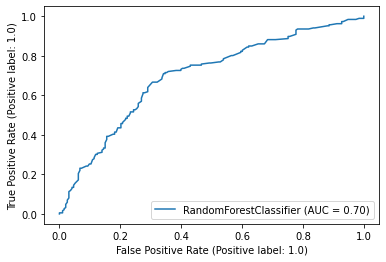

132 wrong out of 379
Accuracy: 0.6517150395778364


In [114]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)
evaluate_model(rfc, X_full, y_full, X_test, y_test)